<a href="https://www.kaggle.com/code/jiyana63/notebook509cb63cd2?scriptVersionId=277156469" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ultralytics

from PIL import Image

import cv2#OpenCV kütüphanesini içe aktarır. Bu, görüntü işleme ve manipülasyonu için kullanılır.
import matplotlib.pyplot as plt#Grafik çizme ve görüntüleri gösterme kütüphanesidir.
from ultralytics import YOLO#YOLOv8 modelini kullanmamızı sağlayan ana kütüphanedir.
import yaml#YAML formatındaki yapılandırma dosyalarını okuma/yazma kütüphanesidir.
import os #İşletim sistemi ile ilgili fonksiyonları (dosya/klasör işlemleri) kullanmamızı sağlar.
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


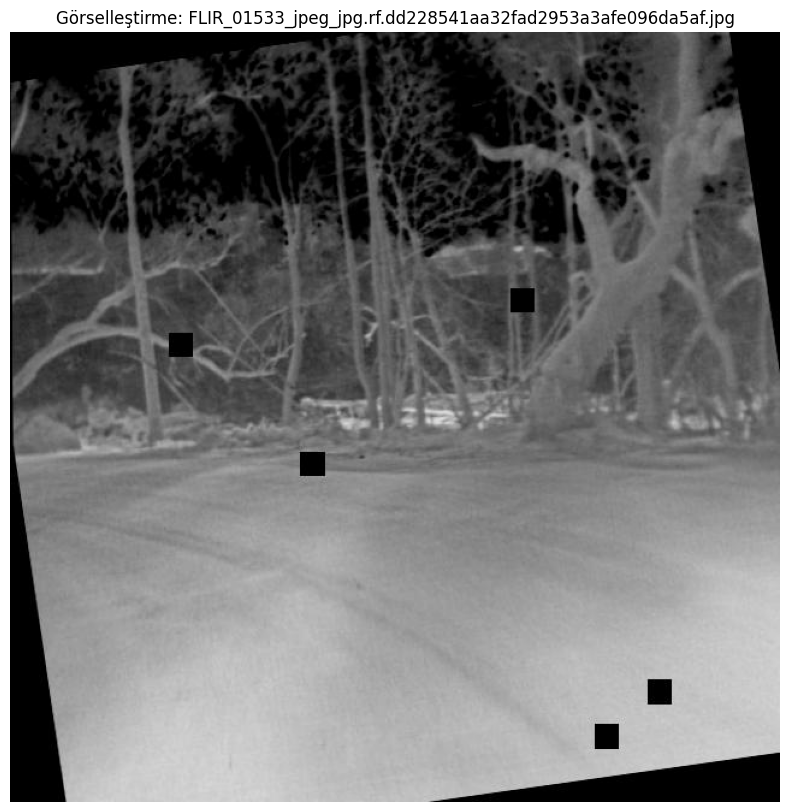

In [2]:
# --- Veri Yolu Tanımlamaları ---
root = "/kaggle/input/thermal-image-people-detection/People Detection - Themal"
train_path = os.path.join(root, "train")
valid_path = os.path.join(root, "valid")

# --- YOLO Koordinat Dönüşüm Fonksiyonu ---
# Dikkat: Parametreler artık isimlendirildi: (label_line, G_ENISLIK, Y_UKSEKLIK)
def yolo_to_pixel(label_line, image_width, image_height):
    class_id, x_center, y_center, width, height = map(float, label_line.split())
    
    # 2. Piksel Değerlerini Hesapla
    w_pixel = width * image_width
    h_pixel = height * image_height
    
    # Sol Üst Köşe (x_min, y_min) Hesaplaması
    x_min = (x_center * image_width) - (w_pixel / 2)
    y_min = (y_center * image_height) - (h_pixel / 2)
    
    # Sağ Alt Köşe (x_max, y_max) Hesaplaması
    x_max = x_min + w_pixel
    y_max = y_min + h_pixel
    
    return int(x_min), int(y_min), int(x_max), int(y_max)

# --- Görselleştirme Fonksiyonu ---
def random_visualize(data_path):
    image_dir = os.path.join(data_path, "images")
    image_list = os.listdir(image_dir)
    if not image_list:
        print("HATA: Görüntü klasörü boş.")
        return
        
    random_filename = random.choice(image_list)
    
    random_image_path = os.path.join(image_dir, random_filename)
    random_label_path = os.path.join(data_path, "labels", random_filename.replace(".jpg", "").replace(".png", "") + ".txt")
    
    # Görüntüyü oku (BGR)
    image = cv2.imread(random_image_path)
    if image is None:
        print(f"HATA: Resim okunamadı: {random_image_path}")
        return

    # Görüntü Boyutları: height=image.shape[0], width=image.shape[1]
    image_height, image_width = image.shape[:2]
    
    label_lines = []
    try:
        with open(random_label_path, 'r') as f:
            label_lines = f.readlines()
    except FileNotFoundError:
        print(f"UYARI: Etiket dosyası bulunamadı: {random_label_path}")
        
    for label_line in label_lines:
        # **DÜZELTME 1: yolo_to_pixel çağrılırken Genişlik (1) ve Yükseklik (0) doğru sırayla gönderildi.**
        x_min, y_min, x_max, y_max = yolo_to_pixel(label_line.strip(), image_width, image_height)
        
        # **DÜZELTME 2: Bounding Box çizildi.**
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) # Yeşil kutu çiz
        print(f"Koordinatlar: ({x_min}, {y_min}, {x_max}, {y_max})")

    # **DÜZELTME 3: Matplotlib için BGR -> RGB Dönüşümü yapıldı.**
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(f"Görselleştirme: {random_filename}")
    plt.axis('off')
    plt.show()

# Fonksiyonu çalıştır
random_visualize(train_path)
plt.show()

In [3]:
from ultralytics import YOLO
import yaml
# WANDB anahtarı (Eğitim takibi için, isteğe bağlı ama faydalıdır)
os.environ['WANDB_API_KEY'] = '4a42c1e3a742bc28d1fc0eaf2bd4cd82e08d1b04'
# Veri yapılandırması
data_yaml = {
    'train': os.path.join(train_path, "images"),
    'val': os.path.join(valid_path,"images"),
    'nc': 1,
    'names': ['person'],
}

with open('dataset.yaml', 'w') as file:
    yaml.dump(data_yaml, file)

print("--- 1. Model: YOLOv8n (Nano) Eğitimi Başlatılıyor ---")
model_nano = YOLO('yolov8n.pt')#En hızlı, en düşük doğruluk.
results_nano = model_nano.train(
   data='dataset.yaml',
   epochs=5,
   imgsz=320,
   batch=16,
   name='yolov8n_custom'
)
# Nano Modelin Doğrulanması ve Dışa Aktarılması
results_nano_val = model_nano.val()
success_nano = model_nano.export(format='onnx', name='yolov8n_custom.onnx')


print("\n--- 2. Model: YOLOv8s (Small) Eğitimi Başlatılıyor ---")
model_small = YOLO('yolov8s.pt')#Dengeli bir seçenek.
results_small = model_small.train(data='dataset.yaml', epochs=5, imgsz=320, name='yolov8s_custom')
# Small Modelin Doğrulanması ve Dışa Aktarılması
results_small_val = model_small.val()
success_small = model_small.export(format='onnx', name='yolov8s_custom.onnx')


print("\n--- 3. Model: YOLOv8m (Medium) Eğitimi Başlatılıyor ---")
model_medium = YOLO('yolov8m.pt')#En yavaş, en yüksek doğruluk (muhtemelen).
results_medium = model_medium.train(data='dataset.yaml', epochs=5, imgsz=320, batch=16, name='yolov8m_custom')
# Medium Modelin Doğrulanması ve Dışa Aktarılması
results_medium_val = model_medium.val()
success_medium = model_medium.export(format='onnx', name='yolov8m_custom.onnx')



print("\n--- SONUÇLARIN ÖZETİ ---")
print(f"YOLOv8n ONNX Aktarımı Başarılı mı?: {success_nano}")
print(f"YOLOv8s ONNX Aktarımı Başarılı mı?: {success_small}")
print(f"YOLOv8m ONNX Aktarımı Başarılı mı?: {success_medium}")

--- 1. Model: YOLOv8n (Nano) Eğitimi Başlatılıyor ---
Ultralytics 8.3.228 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

2025-11-13 09:50:49,802	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-13 09:50:51,219	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics